In [ ]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs


Cloning into 'german-traffic-signs'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (6/6), 117.80 MiB | 5.17 MiB/s, done.
Updating files: 100% (4/4), done.


In [ ]:
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pickle #used to unpickle the the pickled files
import pandas as pd
import random

In [ ]:
np.random.seed(0)

In [ ]:
# with => The primary purpose of the with statement is to simplify the management of resources and prevent common programming errors, such as forgetting to close a file after using it
with open('german-traffic-signs/train.p', 'rb') as f: # 'rb'=> read binary (indicate that we want to open the file in binary mode for reading)
    train_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
    val_data = pickle.load(f)

with open('german-traffic-signs/valid.p', 'rb') as f:
    test_data = pickle.load(f)

print(type(train_data))
print(type(val_data))

x_train, y_train = train_data['features'], train_data['labels']
x_val, y_val = val_data['features'], val_data['labels']
x_test, y_test = test_data['features'], test_data['labels']

#here we have imported and splited the traffic sign data as training, validation and testing data


<class 'dict'>
<class 'dict'>


In [ ]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)


(34799, 32, 32, 3)
(4410, 32, 32, 3)
(4410, 32, 32, 3)


our traffic sign images are 34799 in no. and are RGB images of dimension 32, 32, 3

In [ ]:
# making sure the number of images is equal to the number of labels
assert(x_train.shape[0] == y_train.shape[0]), 'the number of images is not equal to the number of labels'
assert(x_val.shape[0] == y_val.shape[0]), 'the number of images is not equal to the number of labels'
assert(x_test.shape[0] == y_test.shape[0]), 'the number of images is not equal to the number of labels'


In [ ]:
# making sure that our images are 32, 32, 3
assert (x_train.shape[1:] == (32, 32, 3)), 'the dimension of the image is not 32, 32, 3 '
assert (x_val.shape[1:] == (32, 32, 3)), 'the dimension of the image is not 32, 32, 3 '
assert (x_test.shape[1:] == (32, 32, 3)), 'the dimension of the image is not 32, 32, 3 '


In [ ]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
print(data)

    ClassId                                           SignName
0         0                               Speed limit (20km/h)
1         1                               Speed limit (30km/h)
2         2                               Speed limit (50km/h)
3         3                               Speed limit (60km/h)
4         4                               Speed limit (70km/h)
5         5                               Speed limit (80km/h)
6         6                        End of speed limit (80km/h)
7         7                              Speed limit (100km/h)
8         8                              Speed limit (120km/h)
9         9                                         No passing
10       10       No passing for vechiles over 3.5 metric tons
11       11              Right-of-way at the next intersection
12       12                                      Priority road
13       13                                              Yield
14       14                                            

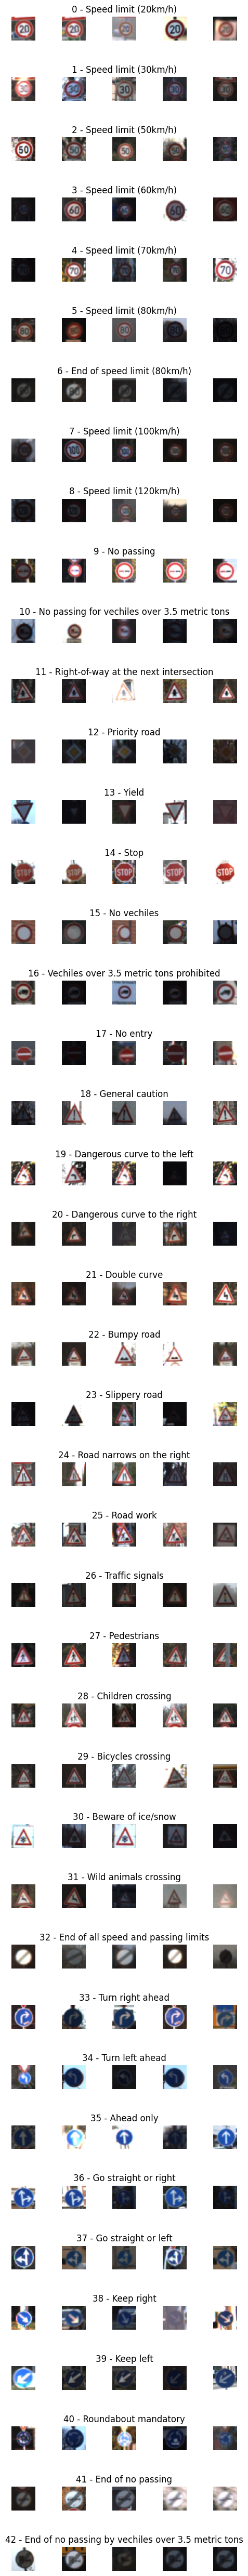

In [ ]:
num_of_samples=[]

cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()

for i in range(cols):
    for j, row in data.iterrows():
      x_selected = x_train[y_train == j]
      axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
      axs[j][i].axis("off")
      if i == 2:
        axs[j][i].set_title(str(j) + " - " + row["SignName"])
        num_of_samples.append(len(x_selected))


[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


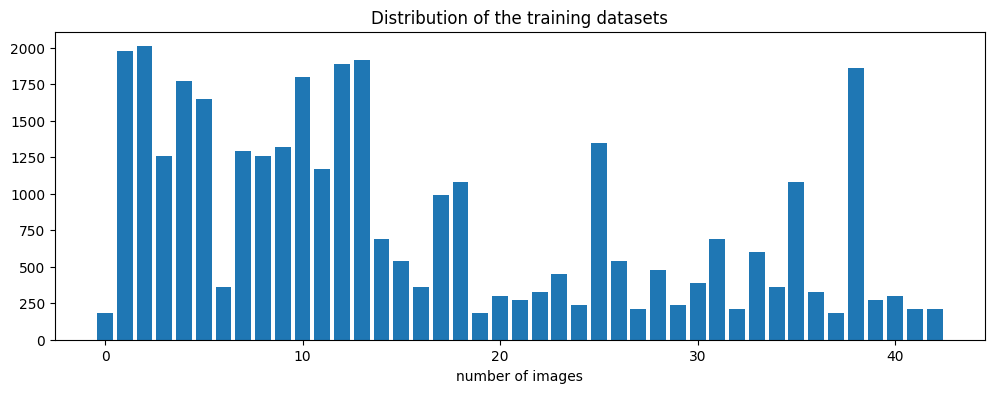

In [ ]:
print(num_of_samples)
plt.figure(figsize=(12,4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title('Distribution of the training datasets')
plt.xlabel('number of images')
plt.show()


(32, 32, 3)
36


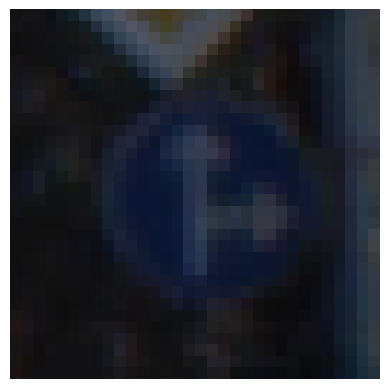

In [ ]:
import cv2

plt.imshow(x_train[1000])
plt.axis('off')
print(x_train[1000].shape)
print(y_train[1000])


(-0.5, 31.5, 31.5, -0.5)

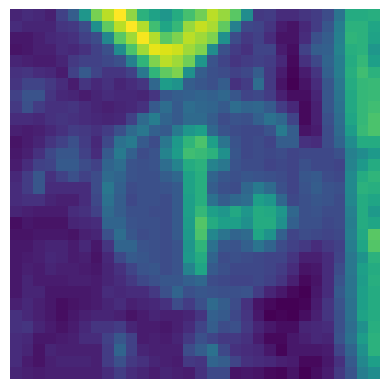

In [ ]:
#converting the image into the gray scale
'''we want to convert the images into the gray scale as
the features of the image like the edges can be detected even in gray scale and the gray scale only has 1 channel so its less parameters for our neural network to train over '''

def grayscale(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return img

img = grayscale(x_train[1000])
plt.imshow(img)
plt.axis('off')



In [ ]:
img.shape

(32, 32)

(32, 32)


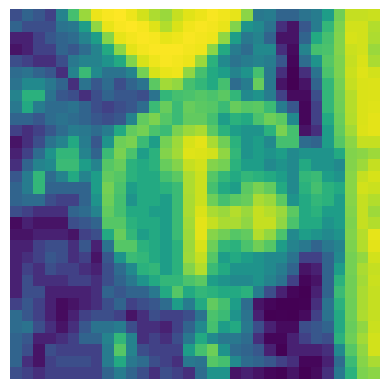

In [ ]:
# hitogram equalization
'''normalizes the pixels intensity for better feature extraction'''

def equalize(img):
  img = cv2.equalizeHist(img)
  return img

img = equalize(img)
plt.imshow(img)
plt.axis('off')
print(img.shape)



In [ ]:
#equalizing the imges
def preprocess(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img

x_train = np.array(list(map(preprocess, x_train)))
x_test = np.array(list(map(preprocess, x_test)))
x_val = np.array(list(map(preprocess, x_val)))

(34799, 32, 32)


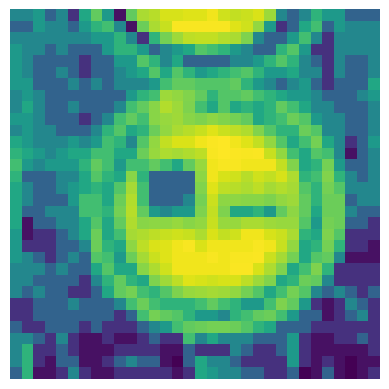

In [ ]:
# printing a random image form the dataset every time the code in run

plt.imshow(x_train[random.randint(0, len(x_train) - 1)])
plt.axis('off')
print(x_train.shape)


In [ ]:
x_train = x_train.reshape(34799, 32, 32, 1)
x_test = x_test.reshape(4410, 32, 32, 1)
x_val = x_val.reshape(4410, 32, 32, 1)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10.)
datagen.fit(x_train)


In [ ]:
#datagen.fit(x_train)
# for X_batch, y_batch in

'''batches = datagen.flow(x_train, y_train, batch_size = 15)
x_batch, y_batch = next(batches)

fig, axs = plt.subplots(1, 15, figsize(20, 5))'''

'batches = datagen.flow(x_train, y_train, batch_size = 15)\nx_batch, y_batch = next(batches)\n\nfig, axs = plt.subplots(1, 15, figsize(20, 5))'

(34799, 32, 32, 1)


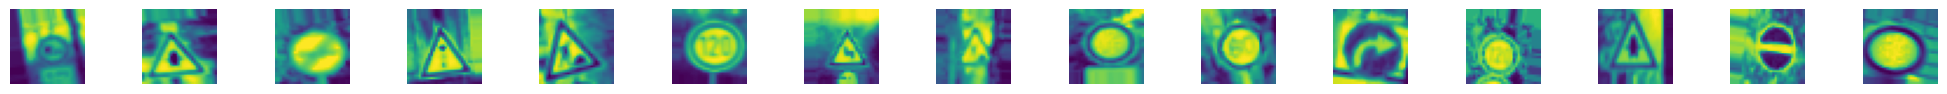

In [ ]:
# here well try get the augmented images inly when required, this helps to keep the computational intensity to be reduced as we call the images only when needed

# for X_batch, y_batch in

batches = datagen.flow(x_train, y_train, batch_size = 100000)
x_batch, y_batch = next(batches)

fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()

for i in range(15):
    axs[i].imshow(x_batch[i].reshape(32, 32))
    axs[i].axis("off")

print(x_batch.shape)

In [ ]:
print(x_train.shape)
print(x_test.shape)
print(x_val.shape)


(34799, 32, 32, 1)
(4410, 32, 32, 1)
(4410, 32, 32, 1)


In [ ]:
#turning the values into hot encoding numbers
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)


In [ ]:
def modified_model():
  model = Sequential()
  model.add(Conv2D(60, (5,5), input_shape=(32,32,1), activation='relu'))
  model.add(Conv2D(60, (5,5), activation='relu'))

  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Conv2D(30, (2,2), activation='relu'))
  model.add(Conv2D(30, (2,2), activation='relu'))

  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(43, activation='softmax'))
  model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model


In [ ]:
model = modified_model()
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 60)        1560      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 60)        90060     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 60)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 11, 30)        7230      
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 30)        3630      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 30)         0         
 2D)                                                    

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


**Finally Training our model**

In [ ]:
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=50),
                            steps_per_epoch=696,
                            epochs=10,
                            validation_data=(x_val, y_val), shuffle = 1)

#history = model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val), batch_size = 400, verbose=1, shuffle=1)

<ipython-input-26-adb89f18c9f5>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=50),


Epoch 1/10
696/696 [==============================] - 26s 22ms/step - loss: 1.8617 - accuracy: 0.4701 - val_loss: 0.3877 - val_accuracy: 0.8850
Epoch 2/10
696/696 [==============================] - 15s 22ms/step - loss: 0.6679 - accuracy: 0.7922 - val_loss: 0.2169 - val_accuracy: 0.9311
Epoch 3/10
696/696 [==============================] - 15s 22ms/step - loss: 0.4138 - accuracy: 0.8717 - val_loss: 0.1955 - val_accuracy: 0.9460
Epoch 4/10
696/696 [==============================] - 15s 21ms/step - loss: 0.3082 - accuracy: 0.9051 - val_loss: 0.1368 - val_accuracy: 0.9628
Epoch 5/10
696/696 [==============================] - 15s 21ms/step - loss: 0.2518 - accuracy: 0.9194 - val_loss: 0.0798 - val_accuracy: 0.9762
Epoch 6/10
696/696 [==============================] - 15s 21ms/step - loss: 0.2131 - accuracy: 0.9330 - val_loss: 0.0783 - val_accuracy: 0.9726
Epoch 7/10
696/696 [==============================] - 16s 22ms/step - loss: 0.1821 - accuracy: 0.9435 - val_loss: 0.0640 - val_accuracy:

Text(0.5, 0, 'epoch')

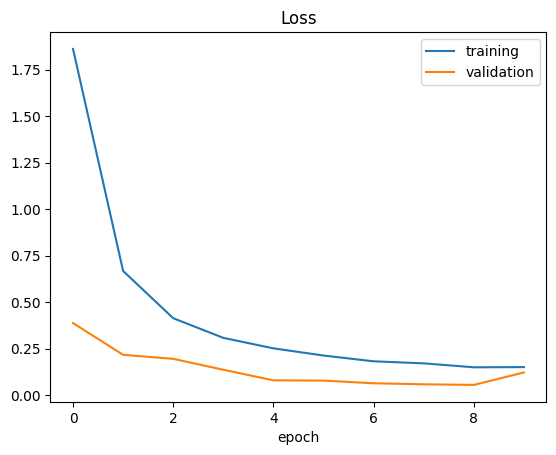

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('epoch')



Text(0.5, 0, 'epoch')

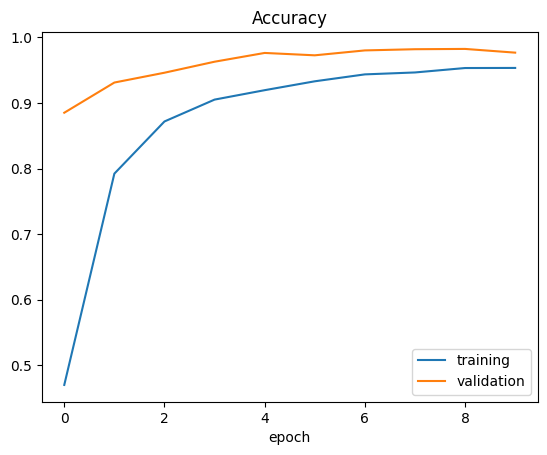

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Accuracy')
plt.xlabel('epoch')

**Clearly the model has overfitted the data as the validation accuracy is lower than the trainig accuracy**

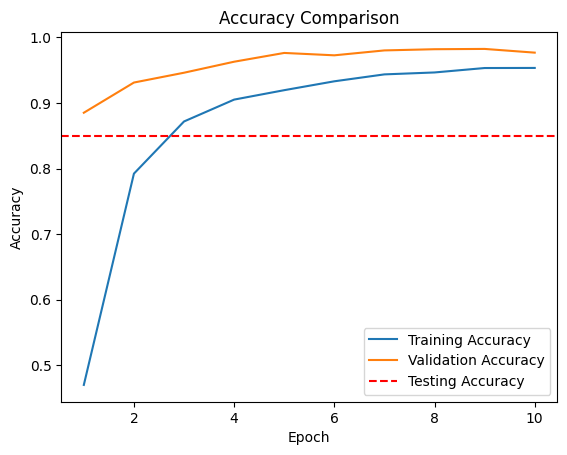

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have history with training and validation accuracy
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Suppose you've evaluated the model on testing data and stored the accuracy
testing_accuracy = 0.85  # Replace with your actual testing accuracy

epochs = range(1, len(training_accuracy) + 1)

plt.plot(epochs, training_accuracy, label='Training Accuracy')
plt.plot(epochs, validation_accuracy, label='Validation Accuracy')
plt.axhline(y=testing_accuracy, color='r', linestyle='--', label='Testing Accuracy')

plt.title('Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
score = model.evaluate(x_test, y_test, verbose=1)
print('test score', score[0])
print('test accuracy', score[1])


138/138 [==============================] - 0s 3ms/step - loss: 0.1222 - accuracy: 0.9766
test score 0.12217850238084793
test accuracy 0.976643979549408


**Fine Tuning our model to reduce the overfitting and increase the accuracy**

for fine tuning the data model we first decresed the learning rate by
0.001 then incresing the number of conv2D layers and to reduce the overfitting we have incerd one layer of dropout

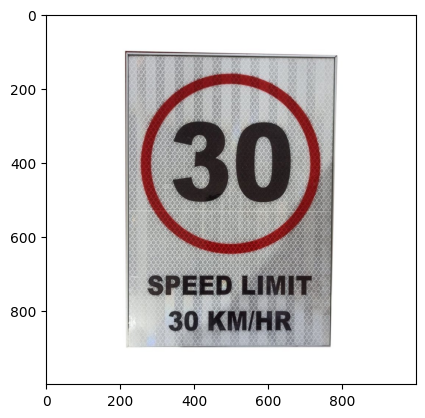

In [ ]:
import requests
from PIL import Image
url = 'https://5.imimg.com/data5/SELLER/Default/2021/12/YS/MR/ZI/139361118/speed-limit-sign-board.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))


(32, 32)


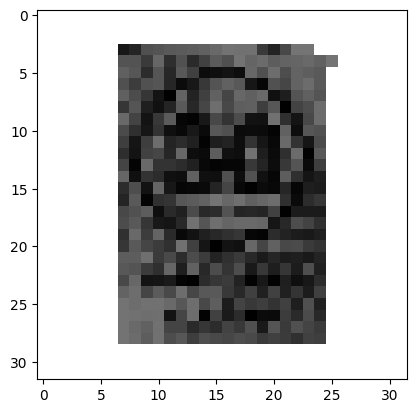

In [ ]:
#Preprocess image

img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocess(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

In [ ]:
#Reshaping reshape to have appropriate depth

img = img.reshape(1, 32, 32, 1)

predictions = model.predict(img)
predicted_class_index = np.argmax(predictions)
print("predicted Sign: ", predicted_class_index)



1/1 [==============================] - 0s 23ms/step
predicted Sign:  5
